In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Data

In [94]:
df1 = pd.read_csv('raw_data/VarScan_results_alignment_1.csv')
df2 = pd.read_csv('raw_data/VarScan_results_alignment_2.csv')
df3 = pd.read_csv('raw_data/VarScan_results_alignment_3.csv')
df_roommate = pd.read_csv('raw_data/VarScan_results_roommate.csv')

df1.frequency = df1.frequency.apply(lambda x: x.strip('%')).astype(float)
df2.frequency = df2.frequency.apply(lambda x: x.strip('%')).astype(float)
df3.frequency = df3.frequency.apply(lambda x: x.strip('%')).astype(float)
df_roommate.frequency = df_roommate.frequency.apply(lambda x: x.strip('%')).astype(float)

# Calculate the average and standard deviation

In [107]:
av1 = df1.frequency.mean()
std1 = df1.frequency.std()

av2 = df2.frequency.mean()
std2 = df2.frequency.std()

av3 = df3.frequency.mean()
std3 = df3.frequency.std()

print('1st control')
print('Average:', round(av1, 3))
print('Standard deviation:', round(std1, 3))

print('2st control')
print('Average:', round(av2, 3))
print('Standard deviation:', round(std2, 3))

print('3st control')
print('Average:', round(av3, 3))
print('Standard deviation:', round(std3, 3))

1st control
Average: 0.256
Standard deviation: 0.072
2st control
Average: 0.237
Standard deviation: 0.052
3st control
Average: 0.25
Standard deviation: 0.078


In [96]:
df = pd.concat([df1, df2, df3])

av = df.frequency.mean()
std = df.frequency.std()

print('Average:', av)
print('Standard deviation:', std)

Average: 0.24829411764705883
Standard deviation: 0.06898268773972734


In [97]:
df_roommate['significant'] = df_roommate.frequency.apply(lambda x: x < av - 3 * std or x > av + 3 * std)
df_roommate[df_roommate.significant == True]

,position,reference_base,alternative_base,frequency,significant
0,72,A,G,99.96,True
1,117,C,T,99.82,True
4,307,C,T,0.94,True
10,774,T,C,99.96,True
14,999,C,T,99.86,True
18,1260,A,C,99.94,True
20,1458,T,C,0.84,True


# Epitopes

In [98]:
epitopes = {
    'A': [122, 124, 126, 130, 131, 132, 133, 135, 137, 138, 140, 142, 143, 144, 145, 146, 150, 152, 168],
    'B': [128, 129, 155, 156, 157, 158, 159, 160, 163, 165, 186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198],
    'C': [44, 45, 46, 47, 48, 50, 51, 53, 54, 273, 275, 276, 278, 279, 280, 294, 297, 299, 300, 304, 305, 307, 
          308, 309, 310, 311, 312],
    'D': [96, 102, 103, 117, 121, 167, 170 , 171, 172, 173, 174, 175, 176, 177, 179, 182, 201, 203, 207, 208, 209, 
          212, 213, 214, 215, 216, 217, 218, 219, 226, 227, 228, 229, 230, 238, 240, 242, 244, 246, 247, 248],
    'E': [57, 59, 62, 63, 67, 75, 78, 80, 81, 82, 83, 86, 87, 88, 91, 92, 94, 109, 260, 261, 262, 265]
}

def find_epitope(x):
    protein_pos = (x - 1) // 3 + 1
    for k in epitopes.keys(): 
        if protein_pos in epitopes[k]: 
            return k
    return None

df_roommate['epitope'] = df_roommate.position.apply(find_epitope)
df_roommate

,position,reference_base,alternative_base,frequency,significant,epitope
0,72,A,G,99.96,True,None
1,117,C,T,99.82,True,None
2,254,A,G,0.17,False,None
3,276,A,G,0.17,False,E
4,307,C,T,0.94,True,D
5,340,T,C,0.17,False,None
6,389,T,C,0.22,False,A
7,691,A,G,0.17,False,None
8,722,A,G,0.20,False,None
9,744,A,G,0.17,False,D


# Save result

In [99]:
df_roommate.to_csv('raw_data/VarScan_results_roommate_sign_epits.csv')

# PCR errors

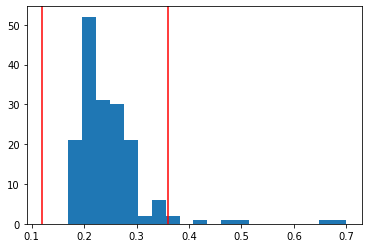

In [105]:
q1, q3 = df.frequency.quantile([0.25, 0.75])
k = 1.5

x1 = q1 - k * (q3 - q1)
x2 = q3 + k * (q3 - q1)

plt.hist(df.frequency, bins=20)
plt.axvline(x=x1, c='r')
plt.axvline(x=x2, c='r')
plt.show()

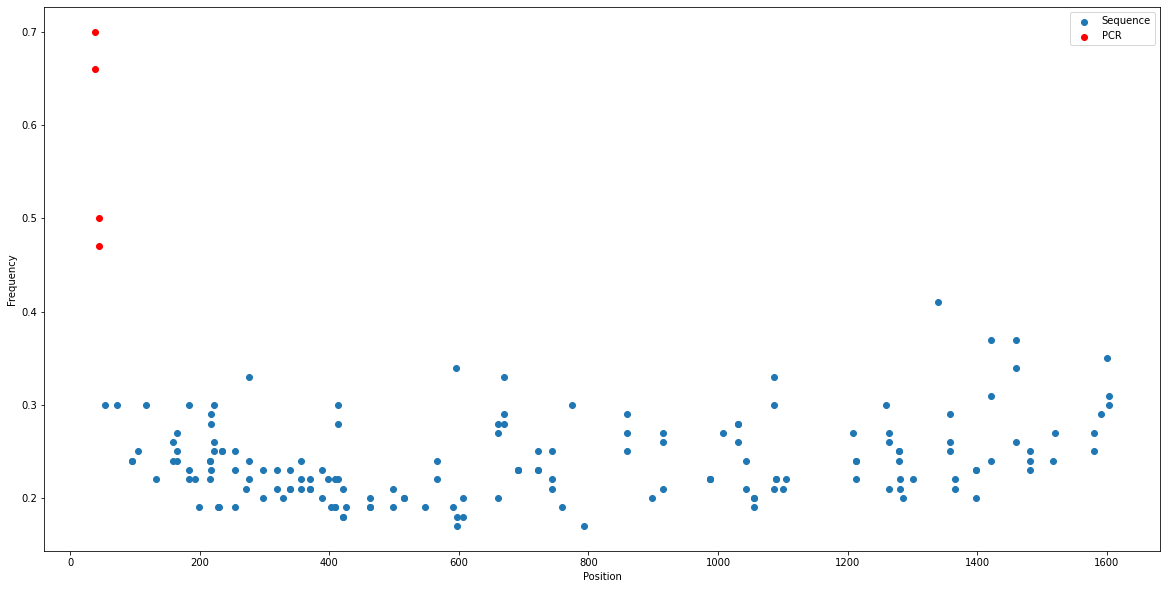

In [101]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df.frequency).reshape(-1, 1))
df['kmeans'] = kmeans.labels_
df.head()

plt.figure(figsize=(20,10))
plt.scatter(df[df.kmeans == 0].position, df[df.kmeans == 0].frequency, label='Sequence')
plt.scatter(df[df.kmeans == 1].position, df[df.kmeans == 1].frequency, c='r', label='PCR')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# PCR and sequencing errors average and standard deviation

In [103]:
print('PCR errors avg:', df[df.kmeans == 1].frequency.mean())
print('PCR errors std:', df[df.kmeans == 1].frequency.std())

print('Read errors avg:', df[df.kmeans == 0].frequency.mean())
print('Read errors std:', df[df.kmeans == 0].frequency.std())

PCR errors avg: 0.5825
PCR errors std: 0.114418821295566
Read errors avg: 0.2402409638554217
Read errors std: 0.04316215805019717
